# Average cases at and after a policy implementation

In this notebook, we investigate if there is an observable correlation between the implementation of some policy and the change in cases / deaths 14 days afterwards.

# 0. Imports

In [1]:
import pandas as pd
from datetime import datetime as dt
from datetime import timedelta
import numpy as np
from covid_project import data_utils as du
from covid_project import deltas_processing as deltas

#from covid_project.data_utils import clean_covid_data, clean_policy_data
#                                      calculate_deltas, generate_state_case_dict,
#                                      calc_delta_stats)
from covid_project.plotting_funcs import plot_delta_stats
from tqdm.notebook import tqdm
import warnings

In [2]:
case_data = du.clean_covid_data()
policy_data = du.clean_policy_data()

# 1. Investigate correlations after 14 days

In [3]:
correlated_df, state_cases_dict = deltas.calculate_deltas(
    case_df = case_data,
    policy_df = policy_data,
    measure_period = 14,
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [17]:
correlated_df.head()

,state,policy_level,date,policy_type,start_stop,county,fips_code,case_14_day_delta,case_14_day_accel,death_14_day_delta,death_14_day_accel
1,Mississippi,county,2020-07-20,outdoor and recreation,stop,sunflower,28133,-21.521182,0.075381,2.676014,0.078073
3,Missouri,state,2020-06-15,non-essential businesses,stop,statewide,29,3.646346,0.028410,-0.422237,-0.002055
5,Georgia,county,2020-04-30,childcare (k-12),stop,fulton,13121,-0.111557,0.025932,-0.097857,0.000070
6,Missouri,county,2020-05-31,entertainment,stop,jackson,29095,0.199421,0.071428,0.020231,0.000000
7,Missouri,state,2021-08-31,mask requirement,stop,statewide,29,5.809236,0.268704,0.859299,-0.069659


In [13]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # lots of numpy warnings for mean of empty slice

    delta_stats = deltas.calc_delta_stats(correlated_df, measure_period=14)

In [14]:
delta_stats.head()

,case_avg,case_accel_avg,death_avg,death_accel_avg,case_std,case_accel_std,death_std,death_accel_std,num_samples
outdoor and recreation - start,0.290244,-0.086085,-0.045676,-0.000613,25.967494,0.648603,0.718209,0.024530,242.0
non-essential businesses - start,-0.597275,-0.104113,-0.071612,-0.000307,26.253823,0.664652,0.743605,0.025037,224.0
childcare (k-12) - start,-2.417826,-0.135299,-0.005124,-0.001843,30.088935,0.795965,0.935644,0.030834,190.0
entertainment - start,-4.194054,-0.106940,-0.060399,-0.001500,24.593333,0.653241,0.780471,0.026467,196.0
mask requirement - start,1.950202,0.022112,0.090919,-0.003435,22.684047,0.632568,1.100998,0.031366,245.0


/home/alex/Documents/personal-projects/Covid-19-correlation-analysis/covid_project/plotting_funcs.py:446: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  n = delta_stats.loc[index][-1]


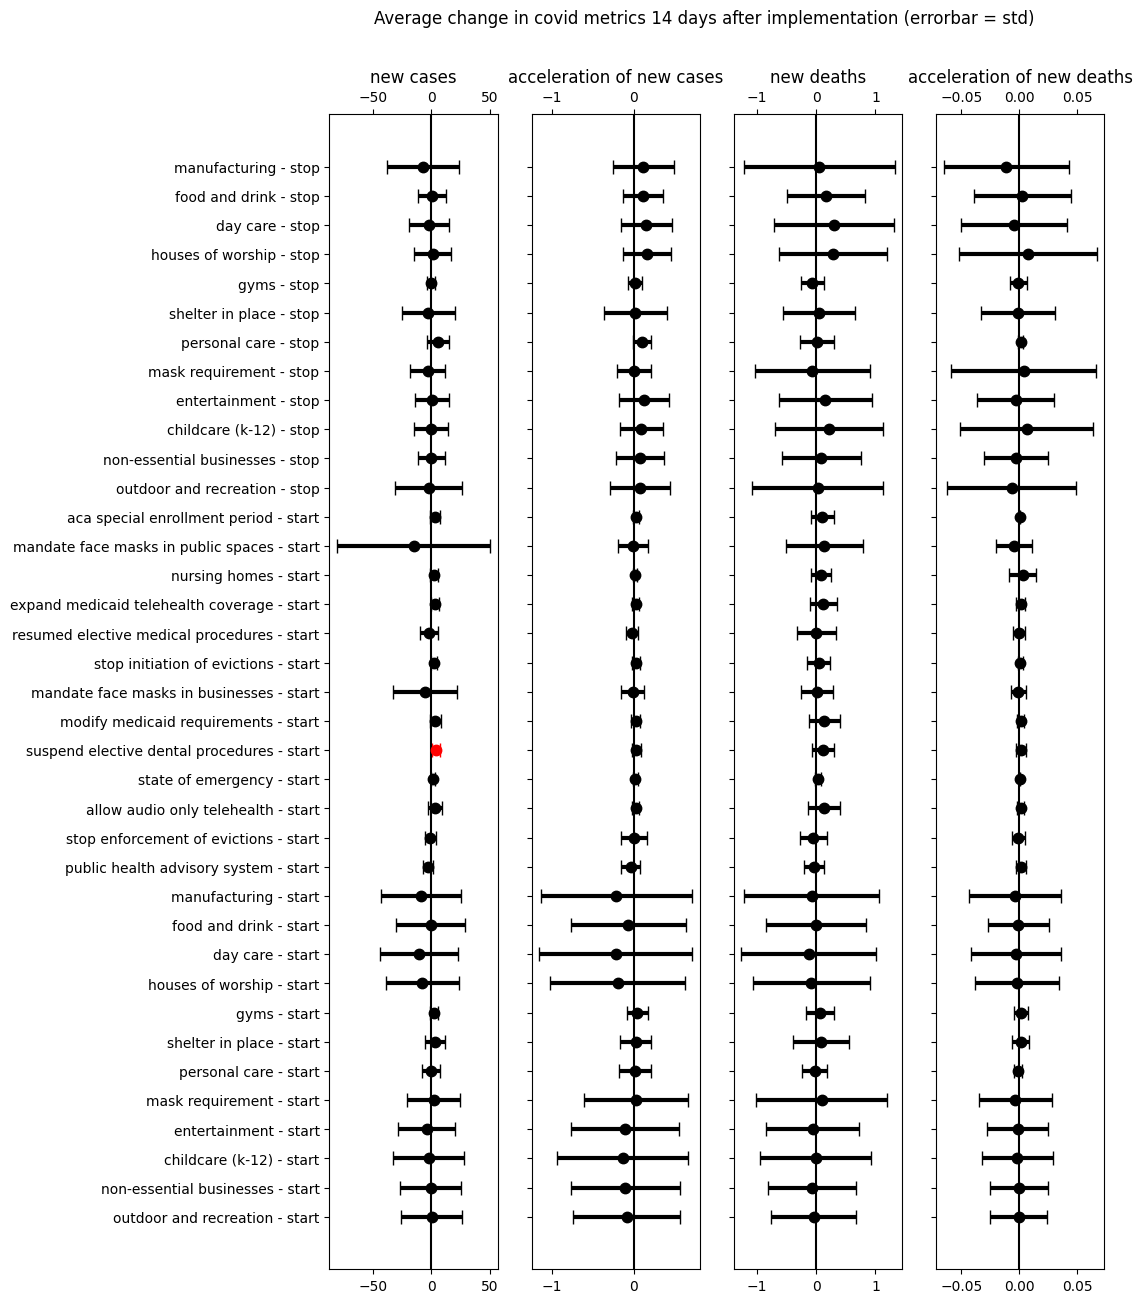

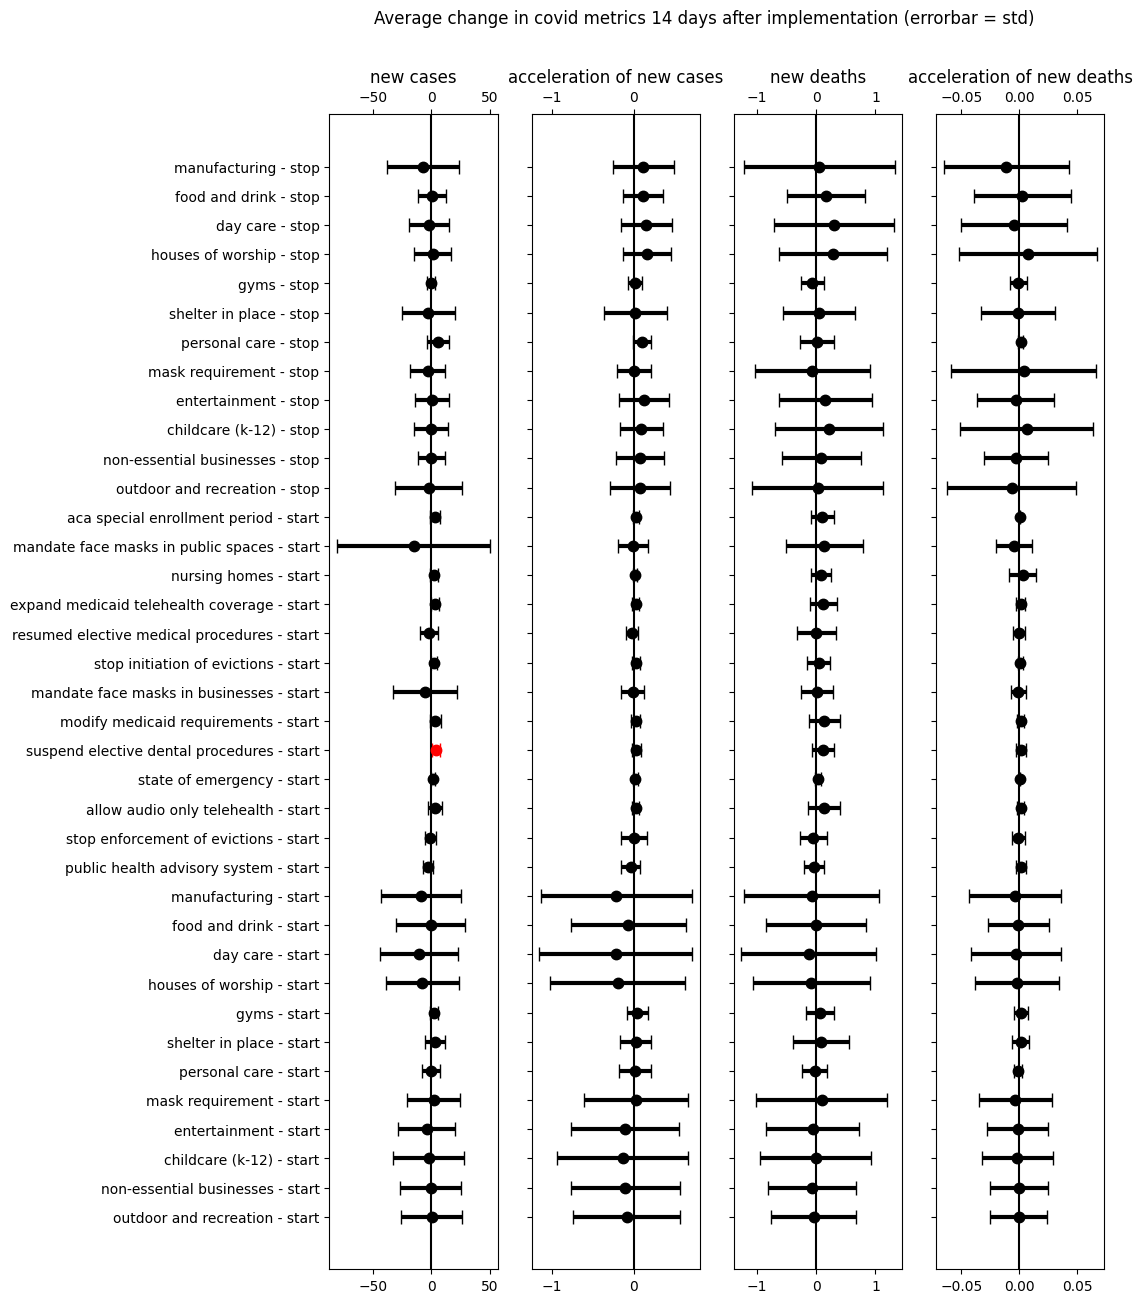

In [15]:
plot_delta_stats(delta_stats,
                 save_figure=True,
                 filename="./figures/average_changes_in_covid_metrics_14_days.png")

After 14 days, there seems to be a signficiant change in new cases 14 days after 'aca-special enrollment period-start', 'suspend elective dental procedues - start' (same with deaths).

Even though these policies give changes that are more than one standard deviation from the mean, I am not convinced that these are actually significant results based on how many show no significance whatsoever and that these policies have relatively small sample sizes compared to the others.

How do these change when we change the measure period?

# 2. Investigate correlations from 1-30 days

In [7]:
# def check_significance(delta_stats):
#     """Adds a column to the delta stats dataframe determining wether the mean change in a given policy is more than 1 standard deviation above / below zero."""
#     cols_of_interest = ['case',  'case_accel', 'death', 'death_accel']
#     for col in cols_of_interest:
#         delta_stats[f"{col}_significant"] = (np.abs(delta_stats[f"{col}_avg"]) -\
#                                                 np.abs(delta_stats[f"{col}_std"])) > 0
#     return delta_stats
# delta_stats = check_significance(delta_stats)

In [8]:
# delta_stats

In [9]:
# def count_significant(delta_stats):
#     """Get the 'significant' policies for cases, case accel, death, and death accel"""
#     cols_of_interest = ['case',  'case_accel', 'death', 'death_accel']
#     res = {col: [] for col in cols_of_interest}
#     for policy in delta_stats.index:
#         for col in cols_of_interest:
#             if delta_stats.loc[policy, f"{col}_significant"]:
#                 res[col].append(policy)
#     return res
# 
# count_significant(delta_stats)

Now, Run the analysis on 1 through 30 days 

In [10]:
# results = dict()
# 
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore") # lots of numpy warnings for mean of empty slice
#     for measure_period in tqdm(range(1, 31)):
#         correlated_df, state_cases_dict = calculate_deltas(
#             case_df = case_data,
#             policy_df = policy_data,
#             measure_period = measure_period,
#         )
#         delta_stats = calc_delta_stats(correlated_df,
#                                        measure_period=measure_period,
#                                        min_samples=3)
#         delta_stats = check_significance(delta_stats)
#         results[measure_period] = count_significant(delta_stats)

In [11]:
# cols_of_interest = ['case',  'case_accel', 'death', 'death_accel']
# results_counts = {num: {
#     col: len(results[num][col]) for col in cols_of_interest
# } for num in results.keys()}

In [12]:
results_counts

NameError: name 'results_counts' is not defined

They all seem to be pretty evenly spread. It looks like this analysis of the differences may not be a good way to model the problem. 